In [157]:
pip install loguru

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [158]:
import timeit

from loguru import logger
from matplotlib import pyplot as plt
import numba as nb
import numpy as np
import pandas as pd
from tqdm import tqdm
import time

In [159]:
np.random.seed(23)


In [160]:
interactions = pd.read_csv('interactions.csv')

# приводим к читаемому виду (как в лекции)
interactions.rename(
    columns={
        'track_id': 'item_id',
        'last_watch_dt': 'datetime',
        'total_dur': 'weight'
    },
    inplace=True)

interactions['datetime'] = pd.to_datetime(interactions['datetime'])


In [161]:
users = pd.read_csv('users.csv')

In [162]:
items = pd.read_csv('items.csv')

In [178]:
def generate_subsample(interactions, users_count, top_k):
    users = np.random.choice(interactions['user_id'].unique(), users_count, replace=False)
    df = interactions[interactions['user_id'].isin(users)].reset_index(drop=True)
    del df['datetime'], df['weight'], df['watched_pct']

    recs = np.random.choice(df['item_id'], size=(users_count, top_k))
    return df, users, recs


In [179]:
def mrr_pandas(df, users, recs, top_k):
    df_r = pd.DataFrame({
        'user_id': np.repeat(users, top_k), 
        'item_id': recs.ravel() 
    })
    # формируем столбик с рангами
    df_r['rank'] = df_r.groupby('user_id').cumcount() + 1

    # мерджим датасет чтобы найти правильные рекомендации
    df_r = df_r.merge(df, how='right', left_on=['user_id', 'item_id'], right_on=['user_id', 'item_id'])

    # берем обратное значение для коненчого расчета и заполяем пропуски
    df_r['revert_rank'] =  1 / df_r['rank']
    df_r['revert_rank'] = df_r['revert_rank'].fillna(0)
    
    mrr = df_r['revert_rank'].sum() / (top_k * len(users))
    return mrr


In [ ]:
print(mrr_pandas(df, users, recs, 10))

In [180]:
def mrr_naive(df, users, recs, top_k):
    mrp = []
    for i, j in enumerate(users):
        mrp_value = 0
        # формируем список для юзера
        user_target = list(df[df['user_id'] == j]['item_id'])
        # Проверяем зашла ли юзеру рекомендашка
        for rank, rec in enumerate(recs[i]):
            if rec in user_target:
                mrp_value += 1 / (rank + 1)
        mrp.append(mrp_value / k)

    return sum(mrp) / len(users)

In [ ]:
print(mrr_naive(df, users, recs, 10))

In [181]:
@nb.njit(cache=True, parallel=True)
def mrr_numba(target, users, recs, k):
    mrp = np.zeros(len(users))
    for i in nb.prange(len(users)):
        mrp_value = 0
       # формируем список для юзера
        user_target = target[target[:, 0] == users[i]][:, 1]
        # Проверяем зашла ли юзеру рекомендашка
        for rank in nb.prange(len(recs[i])):
            if  recs[i][rank] in user_target:
                mrp_value += 1 / (rank + 1)
        mrp[i] = mrp_value / k
    return mrp.mean()


In [182]:
df, users, recs = generate_subsample(interactions=interactions, users_count=100, top_k=10)
target = df.values

In [183]:
print(mrr_numba(target, users, recs, 10))

0.012350793650793652
0.01235079365079365
0.012350793650793652


In [194]:
users_count = [100, 1000, 10000, 100000]
top_k = [10, 50, 100]
time_pandas = []
time_naive = []
time_numba = []
for user in tqdm(users_count):
  for k in top_k:
    df, users, recs = generate_subsample(interactions, user, k)
    target = df.values
    start_time = time.time()
    mrr_pandas(df, users, recs, k)
    time_pandas.append((time.time() - start_time))
    start_time = time.time()
    mrr_naive(df, users, recs, k)
    time_naive.append((time.time() - start_time))
    start_time = time.time()
    mrr_numba(target, users, recs, k)
    time_numba.append((time.time() - start_time))

100%|██████████| 4/4 [11:55<00:00, 178.92s/it]


In [195]:
time_pandas

[0.008580684661865234,
 0.009774923324584961,
 0.00966644287109375,
 0.013853073120117188,
 0.03142237663269043,
 0.02733778953552246,
 0.047275543212890625,
 0.1343703269958496,
 0.26483821868896484,
 0.51971435546875,
 2.147554397583008,
 4.53538179397583]

In [196]:
time_naive

[0.03876066207885742,
 0.05926871299743652,
 0.04381585121154785,
 0.4442174434661865,
 0.5663180351257324,
 0.5487618446350098,
 4.6132566928863525,
 5.002443552017212,
 5.525508880615234,
 96.75317025184631,
 110.99147629737854,
 108.36359572410583]

In [197]:
time_numba

[0.000545501708984375,
 0.00030612945556640625,
 0.0003027915954589844,
 0.013720273971557617,
 0.010856866836547852,
 0.012690544128417969,
 1.1976871490478516,
 1.155242681503296,
 1.1885442733764648,
 121.70533299446106,
 122.71439003944397,
 121.81741642951965]

In [198]:

time_naive_lg = np.log(np.array(time_naive)).reshape((4, 3))
time_numba_lg = np.log(np.array(time_numba)).reshape((4, 3))

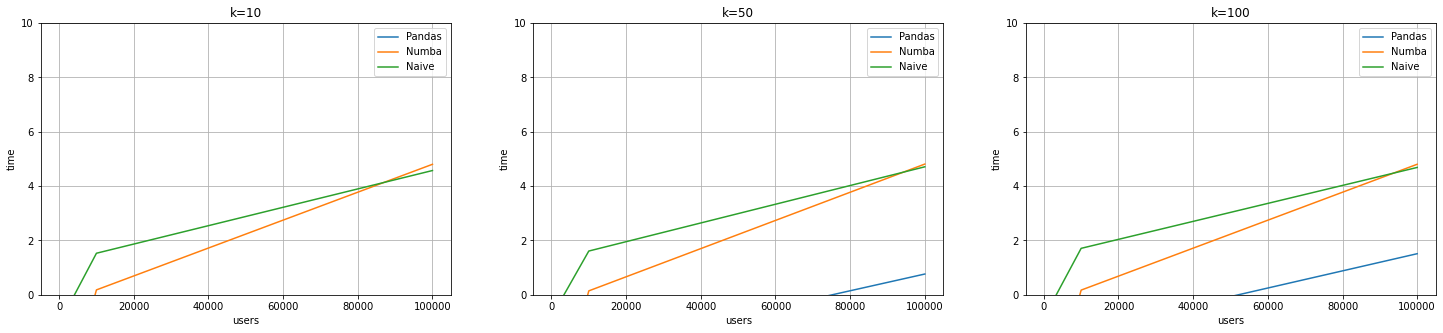

In [208]:
_, ax = plt.subplots(1,3, figsize=(25,5))
for i in range(3):
    ax[i].plot(users_count, time_pandas[:,i], label='Pandas')
    ax[i].plot(users_count, time_numba_lg[:,i], label='Numba')
    ax[i].plot(users_count, time_naive_lg[:,i], label='Naive')    
    ax[i].set_title(f'k={top_k[i]}')
    ax[i].set_xlabel('users')
    ax[i].set_ylabel('time')
    ax[i].set_ylim(0, 10)
    ax[i].grid()
    ax[i].legend()
plt.show()